In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gensim.models import TfidfModel
from gensim.corpora import Dictionary

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, r2_score

from sklearn.model_selection import train_test_split

In [177]:
df_raw = pd.read_csv('../data/interim/preproc.csv', index_col=0)

df = df_raw[(df_raw["lines_added"]>0) & (df_raw['num_commits']<3e5) & (df_raw['lines_removed']<3e6)].dropna()

target = 'lines_modified'
df[target] = df['num_commits']+df['lines_removed']

df.head()

,key,project_id,creation_date,resolution_date,type,lines_added,num_commits,lines_removed,files_changed,duration,text,inter_text,lines_modified
8,EXEC-100,commons-exec,2016-01-11T16:45:23.000+0000,2016-01-11T18:01:01.000+0000,Task,2,189,133,3,1.260556,sync newest ant source file class copy pasta o...,sync with the newest ant source file the class...,322
10,EXEC-98,commons-exec,2016-01-08T21:40:01.000+0000,2016-01-09T00:59:19.000+0000,Bug,3,345,195,11,3.321667,maven site creation fails findbugs error getti...,maven site creation fails with findbugs errors...,540
27,EXEC-81,commons-exec,2014-02-04T04:35:59.000+0000,2014-04-21T23:39:27.000+0000,Improvement,2,35,26,8,1843.057778,remove remaining raw type unchecked conversion...,remove remaining raw types unchecked conversio...,61
28,EXEC-80,commons-exec,2014-02-01T18:38:32.000+0000,2014-02-04T05:20:30.000+0000,Bug,1,32,1,3,58.699444,npe map drilled problem class method checked u...,npe in map i have drilled down a problem in t...,33
33,EXEC-75,commons-exec,2013-12-08T11:42:40.000+0000,2014-06-06T09:12:31.000+0000,Test,1,7,0,1,4317.497500,test matrix update java mac o x hello might in...,test matrix update for java 7 on mac os x hel...,7


# Loading Data

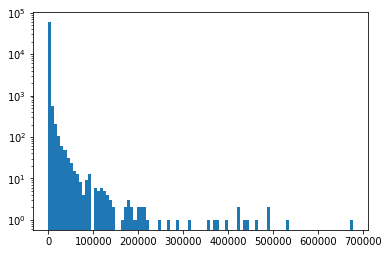

In [178]:
plt.hist(df[target], log=True, bins=100)
plt.show()

In [179]:
X_train, X_test, y_train, y_test = train_test_split(df, df[target], test_size=0.2, random_state=123)

# TF-IDF model

In [223]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train["text"])
svd = TruncatedSVD(n_components=150, random_state=123)
X_train_svd = svd.fit_transform(X_train_tfidf)

X_test_tfidf = vectorizer.transform(X_test["text"])
X_test_svd = svd.transform(X_test_tfidf)

# Modeling

In [224]:
def compute_scores(model, train, test, y_train, y_test, namemodel):
    y_pred = model.predict(train)
    train_abs_error = mean_absolute_error(y_train, y_pred)
    train_sqrt_error = mean_squared_error(y_train, y_pred)
    train_r2_score = r2_score(y_train, y_pred)

    y_pred = model.predict(test)
    test_abs_error = mean_absolute_error(y_test, y_pred)
    test_sqrt_error = mean_squared_error(y_test, y_pred)
    test_r2_score = r2_score(y_test, y_pred)

    print('Absolute error for '+namemodel+':')
    print('- Train:', train_abs_error)
    print('- Test:', test_abs_error)
    print('Squared error for '+namemodel+':')
    print('- Train:', train_sqrt_error)
    print('- Test:', test_sqrt_error)
    print('R2 score for '+namemodel+':')
    print('- Train:', train_r2_score)
    print('- Test:', test_r2_score)

## Linear Regression

In [225]:
lm = LinearRegression().fit(X_train_svd, y_train)

In [226]:
compute_scores(lm, X_train_svd, X_test_svd, y_train, y_test, 'LM')

Absolute error for LM:
- Train: 1539.7923394477427
- Test: 1439.7624455827206
Squared error for LM:
- Train: 85684678.07892965
- Test: 57555023.83764332
R2 score for LM:
- Train: 0.01520025000741032
- Test: 0.004488365067876088


## Ridge Regression

In [227]:
ridge = Ridge().fit(X_train_svd, y_train)

In [228]:
compute_scores(ridge, X_train_svd, X_test_svd, y_train, y_test, 'RIDGE')

Absolute error for RIDGE:
- Train: 1533.7133788172334
- Test: 1433.186173762579
Squared error for RIDGE:
- Train: 85684944.4959189
- Test: 57539309.105335854
R2 score for RIDGE:
- Train: 0.01519718799690517
- Test: 0.004760177983739844


## Gaussian Naive Bayes

In [229]:
gnb = GaussianNB().fit(X_train_svd, y_train)

In [230]:
#compute_scores(gnb, X_train_svd, X_test_svd, y_train, y_test, 'GNB')

## Random Forest Regressor

In [231]:
rf = RandomForestRegressor(max_depth=5).fit(X_train_svd, y_train)

In [232]:
compute_scores(rf, X_train_svd, X_test_svd, y_train, y_test, 'RF')

Absolute error for RF:
- Train: 1376.2119864742106
- Test: 1328.7081553906582
Squared error for RF:
- Train: 69810556.3102766
- Test: 60143188.20573067
R2 score for RF:
- Train: 0.1976463010355889
- Test: -0.040278322003888034


## Multi-layer Perceptron Regressor (NN)

In [233]:
mlp = MLPRegressor(random_state=1, max_iter=800, hidden_layer_sizes=(5,5,5)).fit(X_train_svd, y_train)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


In [234]:
compute_scores(mlp, X_train_svd, X_test_svd, y_train, y_test, 'MLP')

Absolute error for MLP:
- Train: 1297.0390037593627
- Test: 1346.4375076592626
Squared error for MLP:
- Train: 59494648.58792081
- Test: 69014180.24704014
R2 score for MLP:
- Train: 0.31621012800783244
- Test: -0.19371715673403567


In [235]:
nclass = 2

sorted_vals = df[target].sort_values(ignore_index=True).values
nvals = len(sorted_vals)
inter_limits = [sorted_vals[int((i+1)/nclass*nvals)] for i in range(nclass-1)]
limits = np.array([df[target].min(), *inter_limits, df[target].max()])

def get_target(x, limits):
    return np.where(x >= limits)[0][-1]

print(limits)

[     0     64 675989]


In [242]:
# models: lm, ridge, gnb, rf, mlp
y_pred = gnb.predict(X_test_svd)

y_test_class = y_test.apply(get_target, args=(limits,))
y_pred_class = [get_target(y,limits) for y in y_pred]

In [243]:
accuracy_score(y_test_class, y_pred_class)

0.5052746148693905